In [1]:
"""
Koden henter laksedata fra SSB og gjør dataen om til en tabell for alle verdiene som brukes videre i prosjektet ved hjelp av Pandas.
"""

import requests
import pandas as pd
from itertools import product

# URL til SSB API for tabell 03024
API_URL = "https://data.ssb.no/api/v0/no/table/03024/"

def fetch_data(api_url=API_URL):
    """Henter data fra SSB API og returnerer JSON-responsen."""
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    response = requests.post(api_url, json=query)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Feil ved henting av data: {response.status_code}\n{response.text}")

def process_data(data):
    """Prosesserer JSON-data og returnerer en formatert Pandas DataFrame."""
    dimension_names = list(data["dimension"].keys())
    values = data["value"]

    # Kombinasjoner av dimensjoner
    dimensions = [list(data["dimension"][dim]["category"]["label"].values()) for dim in dimension_names]
    all_combinations = list(product(*dimensions))

    # Lag DataFrame og knytt til verdiene
    df = pd.DataFrame(all_combinations, columns=dimension_names)
    df["Value"] = values

    # Pivotér data
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"], values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["Tid", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)", "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]

    # Del opp "Tid" i År og Uke
    df_pivot["År"] = df_pivot["Tid"].str[:4].astype(int)
    df_pivot["Uke"] = df_pivot["Tid"].str[5:].astype(int)
   


    # Fjern "Tid" og omorganiser kolonner slik at År og Uke kommer først
    df_pivot = df_pivot.drop(columns=["Tid"])
    kolonnerekkefølge = ["År", "Uke"] + [col for col in df_pivot.columns if col not in ["År", "Uke"]]
    df_pivot = df_pivot[kolonnerekkefølge]

    # Lag en uke-dato-kolonne for plotting (mandag i hver uke)
    df_pivot["UkeDato"] = pd.to_datetime(df_pivot["År"].astype(str) + "-" + df_pivot["Uke"].astype(str).str.zfill(2) + "-1", format="%Y-%W-%w")


    return df_pivot



def main(): #henter main og behandler dataen og returnerer df_pivot
    try:
        data = fetch_data()
        df_pivot = process_data(data)
        return df_pivot  # returnerer dataene fra main()
    except Exception as e:
        print(e)
        return None

if __name__ == "__main__":
    df_pivot = main()  # mottar resultatet fra main()
    if df_pivot is not None:
        print(df_pivot.to_string(index=False))  # dataene printes her 



  År  Uke  Fersk laks - Kilospris  Fersk laks - Vekt (tonn)  Frosset laks - Kilospris  Frosset laks - Vekt (tonn)    UkeDato
2000    1                   30.98                    3728.0                     32.54                       383.0 2000-01-03
2000    2                   31.12                    4054.0                     33.63                       216.0 2000-01-10
2000    3                   31.03                    4043.0                     36.06                       633.0 2000-01-17
2000    4                   30.95                    3730.0                     34.27                       393.0 2000-01-24
2000    5                   31.30                    3831.0                     33.91                       453.0 2000-01-31
2000    6                   32.53                    4415.0                     35.30                       265.0 2000-02-07
2000    7                   32.46                    4617.0                     34.49                       344.0 2000-02-14


In [2]:
"""
En samlet oversikt over statistisk analyse av laksedataene fra SSB, som viser gjennomsnitt, median og standardavvik for hver variabel over alle år.
"""

import numpy as np
import pandas as pd

#De ulike kolonnene i datasettet som vi bruker
numeriske_kolonner = [
    "Fersk laks - Kilospris", 
    "Fersk laks - Vekt (tonn)", 
    "Frosset laks - Kilospris", 
    "Frosset laks - Vekt (tonn)"
]

#Regner ut statistikken for alle årene til sammen
samlet_statistikk = []

for kol in numeriske_kolonner:
    verdier = df_pivot[kol].dropna()
    samlet_statistikk.append({
        "Variabel": kol,
        "Gjennomsnitt": round(np.mean(verdier), 2),
        "Median": round(np.median(verdier), 2),
        "Standardavvik": round(np.std(verdier), 2)
    })


df_samlet_statistikk = pd.DataFrame(samlet_statistikk)
df_samlet_statistikk.set_index("Variabel", inplace=True)

#visualieres med en tabell som kan scrolle, bruker derfor HTML
from IPython.display import display, HTML

display(HTML(f"""
<div style="width:60%; padding:8px; border:1px solid #ddd; overflow:auto;">
{df_samlet_statistikk.to_html()}
</div>
"""))


,Gjennomsnitt,Median,Standardavvik
Variabel,,,
Fersk laks - Kilospris,45.55,37.94,23.12
Fersk laks - Vekt (tonn),13065.61,13615.50,5762.24
Frosset laks - Kilospris,45.98,40.68,20.77
Frosset laks - Vekt (tonn),625.02,564.00,309.08


Tabellen viser en totaloversikt over de statistiske målene for alle de fire variablene i datasettet. Den gjør det enkelt å oppdage ekstreme verdier eller store avvik fra det som er normalt, og også sesongvariasjoner. For eksempel ser vi at vekten av fersk laks viser større variasjon enn vekten av frossen laks, noe som kan skyldes både høyere eksportvolum og større svingninger gjennom året.
Forskjellen i vekt mellom fersk og frossen laks kan også forklares med at det generelt eksporteres mindre frossen enn fersk laks. Dette gjør at forholdstallet naturligvis blir lavere, forskjellen må derfor tolkes i sammenheng med mønsteret og de andre variablene. 


/var/folders/tm/w7fw79pn5hl46tszbnqf54840000gn/T/ipykernel_31241/2451166172.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_boxpris, x="Kategori", y="Kilospris", palette=["limegreen", "red"], ax=axes[0])
/var/folders/tm/w7fw79pn5hl46tszbnqf54840000gn/T/ipykernel_31241/2451166172.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_boxvekt, x="Kategori", y="Vekt", palette=["hotpink", "mediumorchid"], ax=axes[1])


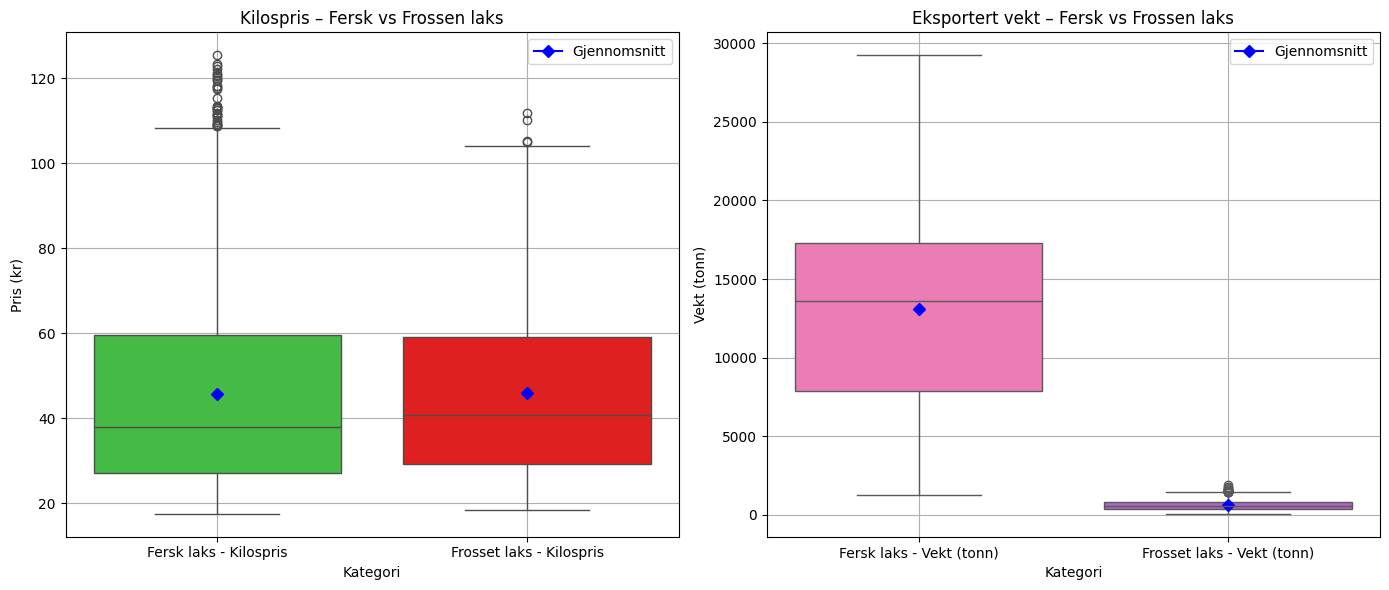

In [3]:

"""
Det kommer to diagrammer med to bokser hver som viser fordelingen for kiloprisen og eksportvekt av fersk og frossen laks.

"""


""" 
    Boksplott for eksportert vekt av fersk og frossen laks
"""


"""
    median vises av streken i midten av boksen 
    standardavvik vises av den laveste streken i diagrammet 
    gjennomsnittet vises av 
    prikkene helt øverst viser uteliggere og ekstreme verdier

"""





import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Gjør klar data
df_boxpris = df_pivot[[
    "Fersk laks - Kilospris", 
    "Frosset laks - Kilospris"
]].melt(var_name="Kategori", value_name="Kilospris")

df_boxvekt = df_pivot[[
    "Fersk laks - Vekt (tonn)", 
    "Frosset laks - Vekt (tonn)"
]].melt(var_name="Kategori", value_name="Vekt")

# Beregn gjennomsnitt for pris
mean_pris = df_boxpris.groupby("Kategori")["Kilospris"].mean()
# Beregner gjennomsnittet for vekt
mean_vekt = df_boxvekt.groupby("Kategori")["Vekt"].mean()

# Lag side-ved-side plott
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Kilopris
sns.boxplot(data=df_boxpris, x="Kategori", y="Kilospris", palette=["limegreen", "red"], ax=axes[0])
axes[0].set_title("Kilospris – Fersk vs Frossen laks")
axes[0].set_ylabel("Pris (kr)")
axes[0].grid(True)

# Legg til gjennomsnitt som horisontale streker
for i, kategori in enumerate(mean_pris.index):
    axes[0].plot(i, mean_pris[kategori], marker="D", color="blue", label="Gjennomsnitt" if i == 0 else "")

# 2. Eksportvekt
sns.boxplot(data=df_boxvekt, x="Kategori", y="Vekt", palette=["hotpink", "mediumorchid"], ax=axes[1])
axes[1].set_title("Eksportert vekt – Fersk vs Frossen laks")
axes[1].set_ylabel("Vekt (tonn)")
axes[1].grid(True)

# Legg til gjennomsnitt for vekt
for i, kategori in enumerate(mean_vekt.index):
    axes[1].plot(i, mean_vekt[kategori], marker="D", color="blue", label="Gjennomsnitt" if i == 0 else "")

# Legg til legende
axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.show()



Kilopris:


Boksplottet visualiserer sentrale statistiske mål som median og standardavvik. 
Gjennomsnitt er ikke inkludert automatisk i plottet, men kan legges til. Man kan her se om prisen er stabil eller om det er store prisforskjeller. 
I dette tilfellet er gjennomsnittet nær medianen, noe som indikerer en jevn fordeling, særlig for frosset laks.
Antallet uteliggere i kategorien for fersk laks kan indikere høysesonger, etterspørselstopper eller enkelte uker med ekstraordinær eksportmengde.


Eksportvekt:

Boksplottet viser fordelingen av ukentlig eksportert vekt (tonn) for fersk og frossen laks.
Boksplottet viser tydelig at fersk laks har et høyere og mer variert eksportvolum per uke enn frossen laks. 
Medianen ligger høyere, og boksen er bredere noe som indikerer større variasjon i vekten.



Boksplottet viser tydelig at fersk laks har et høyere og mer variert eksportvolum per uke enn frossen laks. 
Medianen ligger høyere, og boksen er bredere noe som indikerer større variasjon i vekten.
Det er også flere uteliggere i den ferske kategorien, noe som kan skyldes høysesonger eller spesielle eksporttopper.






In [4]:
from IPython.display import display, HTML
import numpy as np

# Sørg for at du har en 'År'-kolonne i df_pivot
if "År" not in df_pivot.columns:
    df_pivot["År"] = df_pivot["Tid"].str[:4].astype(int)

# Velg numeriske kolonner
numeriske_kolonner = [
    "Fersk laks - Kilospris", 
    "Fersk laks - Vekt (tonn)", 
    "Frosset laks - Kilospris", 
    "Frosset laks - Vekt (tonn)"
]

# Liste for å lagre resultater
statistikk_per_år = []



# Gå gjennom hvert år
for år in sorted(df_pivot["År"].unique()):
    df_år = df_pivot[df_pivot["År"] == år]
    for kol in numeriske_kolonner:
        verdier = df_år[kol].dropna()
        statistikk_per_år.append({
            "År": år,
            "Variabel": kol,
            "Gjennomsnitt": round(np.mean(verdier), 2),
            "Median": round(np.median(verdier), 2),
            "Standardavvik": round(np.std(verdier), 2)
        })


df_stat_år = pd.DataFrame(statistikk_per_år)  #Lager selve dataframen med statistikken før bruk av pivot table til å organisere dataene



# Bruk pivot_table for å gjøre det oversiktlig
pivot = df_stat_år.pivot_table(
    index="År", 
    columns="Variabel", 
    values=["Gjennomsnitt", "Median", "Standardavvik"]
)

# Sorter kolonne-nivåene for penere utskrift
pivot = pivot.sort_index(axis=1, level=0)



for mål in ["Gjennomsnitt", "Median", "Standardavvik"]:
    print(f"\n🔹 {mål}")
    visning = df_stat_år.pivot(index="År", columns="Variabel", values=mål).round(2)
    display(HTML(visning.to_html()))




🔹 Gjennomsnitt


Variabel,Fersk laks - Kilospris,Fersk laks - Vekt (tonn),Frosset laks - Kilospris,Frosset laks - Vekt (tonn)
År,,,,
2000,32.04,5085.94,37.44,640.75
2001,25.99,4989.46,26.96,693.83
2002,23.36,5204.48,23.02,725.63
2003,21.24,6033.48,23.65,865.94
2004,22.57,6426.75,24.48,913.55
2005,26.22,7441.08,27.17,786.69
2006,32.41,7721.75,35.80,827.65
2007,26.68,9595.21,27.26,923.63
2008,27.02,9900.13,28.62,740.15



🔹 Median


Variabel,Fersk laks - Kilospris,Fersk laks - Vekt (tonn),Frosset laks - Kilospris,Frosset laks - Vekt (tonn)
År,,,,
2000,32.33,4963.0,37.14,621.0
2001,26.45,4924.0,28.34,661.0
2002,23.38,5126.0,23.80,704.5
2003,21.75,5986.5,23.94,842.0
2004,22.46,6436.0,24.44,950.0
2005,26.04,7130.5,26.65,756.5
2006,30.92,7246.5,34.58,768.0
2007,26.48,9440.5,27.42,910.0
2008,26.81,9701.0,28.24,741.5



🔹 Standardavvik


Variabel,Fersk laks - Kilospris,Fersk laks - Vekt (tonn),Frosset laks - Kilospris,Frosset laks - Vekt (tonn)
År,,,,
2000,3.37,1054.06,3.50,217.63
2001,1.65,980.75,3.86,245.25
2002,0.70,1329.39,2.67,240.21
2003,1.79,1356.60,1.46,273.43
2004,1.35,1577.49,1.47,258.80
2005,1.66,1523.56,2.56,308.43
2006,5.09,1817.05,5.29,341.15
2007,1.85,1912.74,2.02,295.52
2008,1.47,1787.55,2.19,291.58


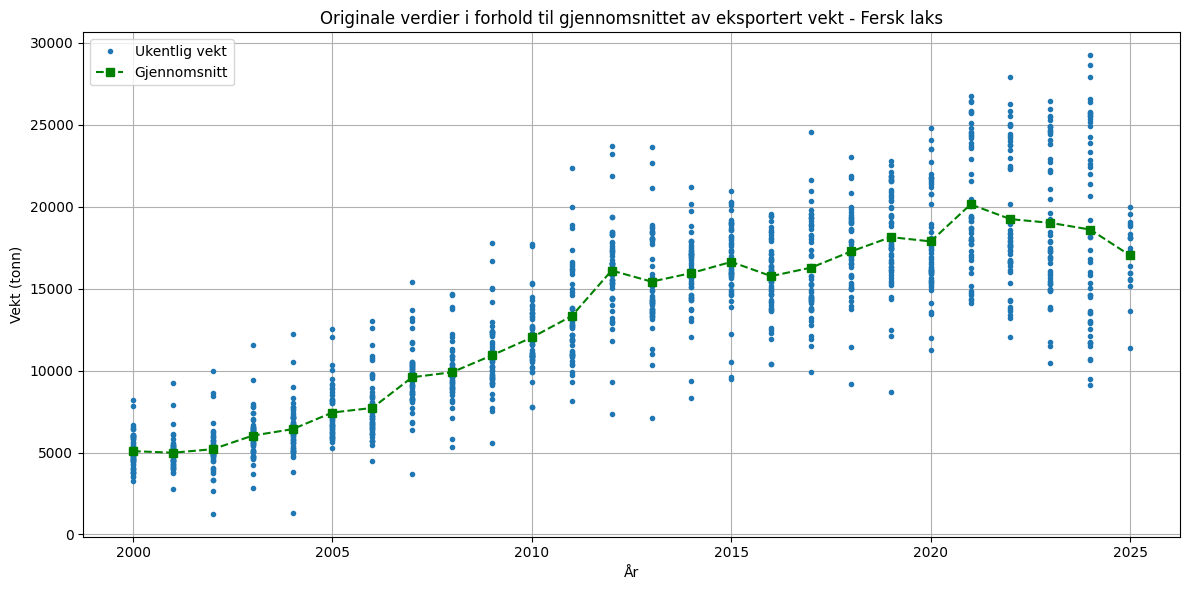

In [5]:
"""
    Lager en graf som viser den ukentlige vekten av fersk laks i forhold til gjennomsnittet for hvert år.
    
"""

plt.figure(figsize=(12, 6))

#plotter en graf for årlig vekt 
plt.plot(df_pivot["År"], df_pivot["Fersk laks - Vekt (tonn)"],
         linestyle="None", marker="o", markersize=3, label="Ukentlig vekt")

#Viser en linje over gjennomsnittet av vekten
df_mean = df_pivot.groupby("År")["Fersk laks - Vekt (tonn)"].mean().reset_index()
plt.plot(df_mean["År"], df_mean["Fersk laks - Vekt (tonn)"],
         linestyle="--", color="green", marker="s", label="Gjennomsnitt")

#faktisk plotting 
plt.title("Originale verdier i forhold til gjennomsnittet av eksportert vekt - Fersk laks")
plt.xlabel("År")
plt.ylabel("Vekt (tonn)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


De blå prikkene viser hver hvor mye vekt som ble eksportert per uke. Dette gjør at man kan se hvor mye variasjon det er per år. Man kan også se ekstremverdiene som er enslige prikker øverst som er uteliggere, det vil si at det har vært noen få uker der eksporten for eksmepel har vært ekstremt høy. Det er tettere prikker der gjennomsnittet ligger. Det er viktig å se på forholdet mellom gjennomsnittet og de faktiske verdiene for å se etter mønster og sesongvariasjon.
Det hadde gjort seg med en sesonggraf for uker da kunne man tydeligere sett om det er noen mønstre eller sesongvariasjoner.